In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/image_verifier/keras/default/1/fundus_autoencoder.keras
/kaggle/input/sample-img/RoP 3.jpg
/kaggle/input/sample-img/RoP 2.jpg


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2025-09-25 07:24:06.600215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758785046.859316      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758785046.920844      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
# --- Configuration (MUST MATCH TRAINING SCRIPT) ---
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 3
MODEL_SAVE_PATH = '/kaggle/input/image_verifier/keras/default/1/fundus_autoencoder.keras'
ANOMALY_THRESHOLD = 0.000974

In [4]:
def preprocess_image(file_path):
    """Loads and preprocesses a single image for model prediction."""
    img = tf.io.read_file(file_path)
    img = tf.io.decode_image(img, channels=IMAGE_CHANNELS, expand_animations=False)
    img_resized = tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])
    img_normalized = tf.cast(img_resized, tf.float32) / 255.0
    img_batch = tf.expand_dims(img_normalized, axis=0)
    # Return original decoded image for visualization
    return img_batch, tf.cast(img, tf.uint8)

In [5]:
def classify_image_quality(model, image_path, threshold):
    """
    Classifies a single fundus image and returns classification, error, and images.
    """
    if not os.path.exists(image_path):
        print(f"Error: Image path not found at '{image_path}'")
        return None

    # --- 1. Preprocess the image ---
    input_image_batch, original_image_for_viz = preprocess_image(image_path)

    # --- 2. Get the model's prediction (the reconstructed image) ---
    reconstructed_image_batch = model.predict(input_image_batch)

    # --- 3. Calculate the reconstruction error (MSE) ---
    mse = np.mean(np.square(input_image_batch - reconstructed_image_batch))

    # --- 4. Compare error to the threshold for classification ---
    classification = 'Good Quality' if mse <= threshold else 'Poor Quality (Anomaly)'
    
    # Squeeze the batch dimension for visualization
    reconstructed_image_for_viz = np.squeeze(reconstructed_image_batch, axis=0)

    return classification, mse, original_image_for_viz, reconstructed_image_for_viz


Loading model from: /kaggle/input/image_verifier/keras/default/1/fundus_autoencoder.keras


2025-09-25 07:25:10.160605: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model loaded successfully.


I0000 00:00:1758785111.203471      87 service.cc:148] XLA service 0x7daa94008560 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758785111.204362      87 service.cc:156]   StreamExecutor device (0): Host, Default Version


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


I0000 00:00:1758785111.739324      87 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



--- Classification Result ---
Image: /kaggle/input/sample-img/RoP 2.jpg
Reconstruction Error (MSE): 0.000786
Anomaly Threshold:          0.000974
Verdict: Good Quality


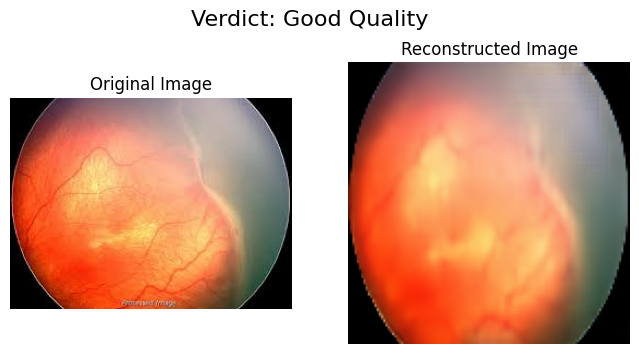

In [9]:
if __name__ == '__main__':
    # --- 1. Load the trained model ---
    if not os.path.exists(MODEL_SAVE_PATH):
        print(f"Error: Model file not found at '{MODEL_SAVE_PATH}'. Please train the model first.")
    else:
        print(f"Loading model from: {MODEL_SAVE_PATH}")
        autoencoder = tf.keras.models.load_model(MODEL_SAVE_PATH)
        print("Model loaded successfully.")

        # --- 2. Define path to the image you want to test ---
        # !!! REPLACE THIS with the path to your image !!!
        image_to_test = '/kaggle/input/sample-img/RoP 2.jpg'

        # --- 3. Perform the classification ---
        result = classify_image_quality(autoencoder, image_to_test, ANOMALY_THRESHOLD)

        # --- 4. Print the result and visualize ---
        if result:
            classification, error, original, reconstructed = result
            print("\n--- Classification Result ---")
            print(f"Image: {image_to_test}")
            print(f"Reconstruction Error (MSE): {error:.6f}")
            print(f"Anomaly Threshold:          {ANOMALY_THRESHOLD:.6f}")
            print(f"Verdict: {classification}")

            # Visualize the original vs reconstructed
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.title("Original Image")
            plt.imshow(original)
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title("Reconstructed Image")
            plt.imshow(reconstructed)
            plt.axis('off')
            
            plt.suptitle(f"Verdict: {classification}", fontsize=16)
            plt.show()
